# Notebook setup

In [1]:
import os
import sys
import logging
import tracemalloc
import time

import pandas as pd
import tensorflow as tf
import sklearn as sk
import skopt as so
import numpy as np

from pickle import dump

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)

tf.random.set_seed(42)
np.random.seed(42)

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations
from skopt import gp_minimize

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sk.__version__}")
print(f"SciKit Optimize {so.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

/home/siderealyear/anaconda3/envs/wildfire_production/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1
SciKit Optimize 0.4

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


# 1. Data preparation

In [2]:
# read data
data_file = '/mnt/SSD/data/training_data/1992-2015_california_min-1_max1_scaled_mean.parquet'
raw_data = pd.read_parquet(data_file)

# make sure data is sorted by date
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data = raw_data.set_index('date')
raw_data = raw_data.sort_index()
raw_data.reset_index(inplace=True)
raw_data.drop(['month', 'total_fires'], inplace=True, axis=1)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 14 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   lat               float32       
 2   lon               float32       
 3   apcp              float32       
 4   mean_air_2m       float32       
 5   mean_rhum_2m      float32       
 6   mean_dpt_2m       float32       
 7   mean_pres_sfc     float32       
 8   mean_uwnd_10m     float32       
 9   mean_vwnd_10m     float32       
 10  mean_cloud_cover  float32       
 11  ignition          int32         
 12  raw_lat           float32       
 13  raw_lon           float32       
dtypes: datetime64[ns](1), float32(12), int32(1)
memory usage: 205.7 MB


In [3]:
geospatial_bins = raw_data[['raw_lat', 'raw_lon']]
geospatial_bins.head(n=20)

,raw_lat,raw_lon
0,32.683891,-117.180901
1,38.961529,-123.557899
2,35.232731,-117.260803
3,38.575668,-120.454903
4,37.182751,-121.959801
5,38.978210,-121.676399
6,40.208530,-123.153397
7,36.557789,-120.359802
8,35.209370,-119.710999
9,41.740639,-122.811699


### Randomly chosen geospatial bins
1. Grass Valley Wilderness Area, Barstow: 35.232731, -117.260803
2. Lexington Hills: 37.182751, -121.959801
3. Cantua Creek: 36.557789, -120.359802
4. Klamath: 41.552299, -123.944199

In [4]:
barstow = raw_data[(raw_data['raw_lat'] == 35.232731) & (raw_data['raw_lon'] == -117.260803)]
lexington = raw_data[(raw_data['raw_lat'] == 37.182751) & (raw_data['raw_lon'] == -121.959801)]
cantua = raw_data[(raw_data['raw_lat'] == 36.557789) & (raw_data['raw_lon'] == -120.359802)]
klamath = raw_data[(raw_data['raw_lat'] == 41.552299) & (raw_data['raw_lon'] == -123.944199)]

print(f'Num time points: {len(klamath)}')
print()

data = pd.concat([barstow, lexington, klamath])
data.info()

Num time points: 8766

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26298 entries, 2 to 3593914
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              26298 non-null  datetime64[ns]
 1   lat               26298 non-null  float32       
 2   lon               26298 non-null  float32       
 3   apcp              26298 non-null  float32       
 4   mean_air_2m       26298 non-null  float32       
 5   mean_rhum_2m      26298 non-null  float32       
 6   mean_dpt_2m       26298 non-null  float32       
 7   mean_pres_sfc     26298 non-null  float32       
 8   mean_uwnd_10m     26298 non-null  float32       
 9   mean_vwnd_10m     26298 non-null  float32       
 10  mean_cloud_cover  26298 non-null  float32       
 11  ignition          26298 non-null  int32         
 12  raw_lat           26298 non-null  float32       
 13  raw_lon           26298 non-null  float32       
dt

In [5]:
class_0_weight = ()
class_1_weight = ()
bins = data.groupby(['raw_lat', 'raw_lon'])

for name, spatial_bin in bins:
    fires = spatial_bin['ignition'].sum()
    
    if fires == 0:
        class_0_weight = class_0_weight + (1,)
        class_1_weight = class_1_weight + (1,)
    
    else:
        observations = len(spatial_bin)
        class_0_weight = class_0_weight + (((1 / (observations - fires))*(observations)/2.0),)
        class_1_weight = class_1_weight + (((1 / fires)*(observations)/2.0),)
        
print(f'Class 0 weights: {class_0_weight}')
print(f'Class 1 weights: {class_1_weight}')

Class 0 weights: (0.5006282124500285, 0.5665718717683558, 0.5122122239102489)
Class 1 weights: (398.45454545454544, 4.255339805825242, 20.971291866028707)


In [6]:
num_fires = data['ignition'].sum()
total_observations = len(data)
raw_output_bias = np.log([num_fires/(total_observations - num_fires)])[0]
output_bias = tf.keras.initializers.Constant(raw_output_bias)

print(f'Output bias: {raw_output_bias}')

Output bias: -2.9976504327098947


### Split data into training, validation and testing sets
Note: since temporal order matters here, we cannot simply randomly sample the data - we need to preserve the order. One possible improvement could be to break the data into many smaller ordered chunks and then sample those randomly...

In [7]:
# make sure data is STILL sorted by date
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.sort_index()
data.reset_index(inplace=True)

# Split data up into training, testing and validation sets
testing_data = data.tail(int(len(data) * 0.2))
leftover_data = data.head(int(len(data) * 0.8))
validation_data = data.tail(int(len(leftover_data) * 0.5))
training_data = data.head(int(len(leftover_data) * 0.5))

Let's compare the distributions of each weather variable across the train, validation and test sets just to be sure that our samples are matched to a first approximation.

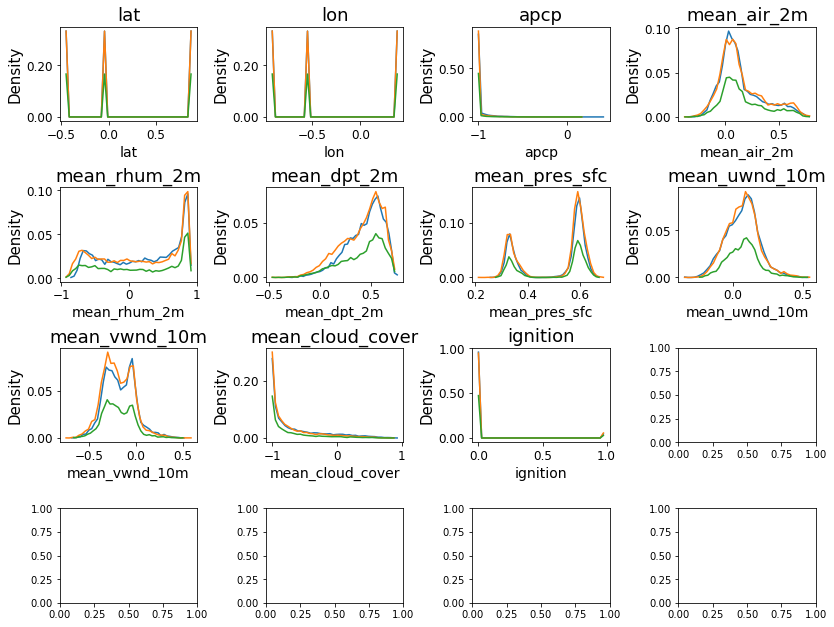

In [8]:
# plot split data distributions
features = [
    'lat',
    'lon',
#     'month',
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',       
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
#     'total_fires',
    'ignition'
#     'range_air_2m',
#     'range_rhum_2m', 
#     'range_dpt_2m',
#     'range_pres_sfc',
#     'range_uwnd_10m',
#     'range_vwnd_10m',
#     'range_vis',
#     'range_cloud_cover'
]

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
]

xlabels = features
ylabels = ['Density'] * len(features)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        testing_data, 
        features[i], 
        features[i], 
        features[i], 
        ylabels[i]
    )
    
plt.show()

# 2. Set up gaussian process optimization

In [9]:
# metrics to track
metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation,
    data_functions.f1
]

#metrics = config.metrics

# dimensions to include in GPM search space
dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=5, 
    name='past_history'
)

dim_batch_size = Integer(
    low=32,
    high=128,
    name='batch_size'
)

dim_rnn_type = Integer(
    low=0,
    high=1,
    name='rnn_type'
)

dim_statefullness = Integer(
    low=0,
    high=1,
    name='statefullness'
)

dim_rnn_units = Integer(
    low=1, 
    high=10,
    name='rnn_units'
)

dim_rnn_dropout = Real(
    low=0.0, 
    high=0.5,
    name='rnn_dropout'
)

dim_fc_unit_factor = Integer(
    low=2, 
    high=10,
    name='fc_unit_factor'
)

dim_fc_layers = Integer(
    low=0, 
    high=5,
    name='fc_layers'
)

dim_fc_l2_reg = Real(
    low=0.0, 
    high=0.3,
    name='fc_l2_reg'
)

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_batch_size,
    dim_rnn_type,
    dim_statefullness,
    dim_rnn_units,
    dim_rnn_dropout,
    dim_fc_unit_factor,
    dim_fc_layers,
    dim_fc_l2_reg
    
]

default_parameters = [0.01, 5, 64, 1, 1, 10, 0.1, 3, 3, 0.0]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    mode = 'min',
    restore_best_weights = True
)

future_target = 1
step = 1
EPOCHS = 20

# also set initial value for output bias based on fire frequency
# raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
# output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/small_scale_parallel_RNN_optimization.keras'
best_val_loss = 1000

run_num = 1
total_elapsed = 0.0

In [10]:
def make_model(
    num_bins,
    input_shape,
    learning_rate,
    rnn_type,
    statefullness,
    rnn_units,
    rnn_dropout,
    fc_unit_factor,
    fc_layers,
    fc_l2_reg,
    class_0_weight,
    class_1_weight,
    output_bias
):    
    
    if statefullness == 0:
        statefullness = False
        
    elif statefullness == 1:
        statefullness = True
    
    inputs = []
    RNNs = []

    # make list of inputs, one for each geospatial bin
    for i in range(num_bins):
        inputs.append(
            keras.Input(
                batch_shape=input_shape
            )
        )
    
    if rnn_type == 0:
        # make list of LSTM layers, one for each geospatial bin
        for i in range(num_bins):
            RNNs.append(keras.layers.LSTM(
                rnn_units,
                dropout=rnn_dropout,
                stateful=statefullness
            )(inputs[i]))
            
    elif rnn_type == 1:
        # make list of GRU layers, one for each geospatial bin
        for i in range(num_bins):
            RNNs.append(keras.layers.GRU(
                rnn_units,
                dropout=rnn_dropout,
                stateful=statefullness
            )(inputs[i]))

    # merge LSTM layers with concat layer
    merged = keras.layers.concatenate(RNNs)
    
    if fc_layers == 0:
        # output layer
        output = keras.layers.Dense(
            num_bins,
            activation='sigmoid',
            bias_initializer=output_bias
        )(merged) 
        
    
    elif fc_layers > 0:
        i = 0
        io_layers = []
        io_layers.append(merged)
        
        while i <= fc_layers:
            # add fully connected layer
            io_layers.append(keras.layers.Dense(
                (num_bins * fc_unit_factor),
                kernel_regularizer=regularizers.l2(fc_l2_reg),
                bias_initializer=keras.initializers.VarianceScaling(
                    scale=1.0,
                    mode='fan_in', 
                    distribution='normal', 
                    seed=42
                ),
                activation = 'relu'
            )(io_layers[i]))

            i += 1

        # output layer
        output = keras.layers.Dense(
            num_bins,
            activation='sigmoid',
            bias_initializer=output_bias
        )(io_layers[-1])        

    # compile model
    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr = learning_rate),
        loss = data_functions.weighted_bce(class_0_weight, class_1_weight),
        metrics = metrics
    )

    return model

In [11]:
@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    batch_size,
    rnn_type,
    statefullness,
    rnn_units,
    rnn_dropout,
    fc_unit_factor,
    fc_layers,
    fc_l2_reg
):
    
    # create data sets
    x_training, y_training, training_lats, training_lons, training_dates = data_functions.format_features_labels_for_LSTM(
        training_data,        # incomming_data
        past_history,         # size of past history time chunk
        future_target,        # number of future timepoints to predict from each history time chunk
        step,                 # number of timepoints to move the history time chunk as we slide over the data
    )

    x_validation, y_validation, validation_lats, validation_lons, validation_dates = data_functions.format_features_labels_for_LSTM(
        validation_data,      # incomming_data
        past_history,         # size of past history time chunk
        future_target,        # number of future timepoints to predict from each history time chunk
        step,                 # number of timepoints to move the history time chunk as we slide over the data
    )
    
    x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)
    x_validation, y_validation = data_functions.trim_and_reshape_for_LSTM(x_validation, y_validation)
    
    # trim datasets so they are a whole number factor of the batch size
    for i in range(len(x_training)):
        start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % batch_size))
        end_index = x_training[i].shape[0]

        x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

    y_training = np.delete(y_training, range(start_index, end_index), axis=0)

    for i in range(len(x_validation)):
        start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % batch_size))
        end_index = x_validation[i].shape[0]

        x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
#     print()
#     print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
#     print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
#     print()
#     print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
#     print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
#     print()

    input_dim = x_training[0].shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    num_bins = len(x_training)
#     print(f'Input shape: {input_shape}')
#     print(f'Num bins: {num_bins}')
#     print()
    
    # steps from batch size
    steps_per_epoch = int(len(x_training[0]) // batch_size)
    validation_steps = int(len(x_validation[0]) // batch_size)
    
#     print(f'Batch size: {batch_size}')
#     print(f'Training steps: {steps_per_epoch}')
#     print(f'Validation steps: {validation_steps}')
#     print(f'Fully connected layers: {fc_layers}')
#     print()
    
    # Create the neural network with these hyper-parameters.
    
#     fc_unit_factor = 0
#     fc_layers = 0
#     fc_l2_reg = 0
    
    model = make_model(
        num_bins=num_bins,
        input_shape=input_shape,
        learning_rate=learning_rate,
        rnn_type=rnn_type,
        statefullness=statefullness,
        rnn_units=rnn_units,
        rnn_dropout=rnn_dropout,
        fc_unit_factor=fc_unit_factor,
        fc_layers=fc_layers,
        fc_l2_reg=fc_l2_reg,
        class_0_weight=class_0_weight,
        class_1_weight=class_1_weight,
        output_bias=output_bias
    )
    
#     model.summary()
    
    global run_num
    global total_elapsed
    
    # Use Keras to train the model
    start = time.time()
    
    history = model.fit(
        x_training,
        y_training,
        epochs=EPOCHS,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        callbacks=[early_stopping_callback],
        validation_data=(x_validation, y_validation),
        validation_steps=validation_steps,
        verbose=0
    )
    
    end = time.time()
    elapsed = (end - start) / 60
    total_elapsed = total_elapsed + elapsed

    # Get validation loss for training run
    val_loss = history.history['val_loss'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_val_loss

    # If the validation loss of the saved model is improved ...
    if val_loss < best_val_loss:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_val_loss = val_loss
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    if run_num % 10 == 0:
        print(f'Run {run_num}, {np.round(total_elapsed, 1)} min. elapsed in model.fit(), best validation loss so far: {np.round(best_val_loss, 2)}')
    
    run_num += 1
        
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return val_loss

In [12]:
%%time

# do the optimization run
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=50,
    x0=default_parameters
)

Run 10, 4.6 min. elapsed in model.fit(), best validation loss so far: 0.64
Run 20, 8.6 min. elapsed in model.fit(), best validation loss so far: 0.64
Run 30, 13.7 min. elapsed in model.fit(), best validation loss so far: 0.64
Run 40, 19.9 min. elapsed in model.fit(), best validation loss so far: 0.64
Run 50, 25.8 min. elapsed in model.fit(), best validation loss so far: 0.64
CPU times: user 37min 14s, sys: 3min 14s, total: 40min 28s
Wall time: 28min 22s


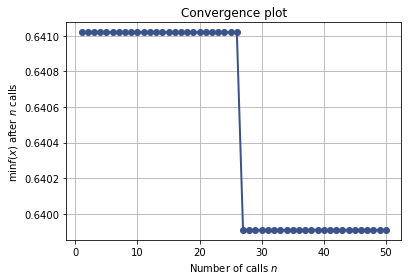

In [13]:
from skopt.plots import plot_convergence
plot_convergence(search_result)

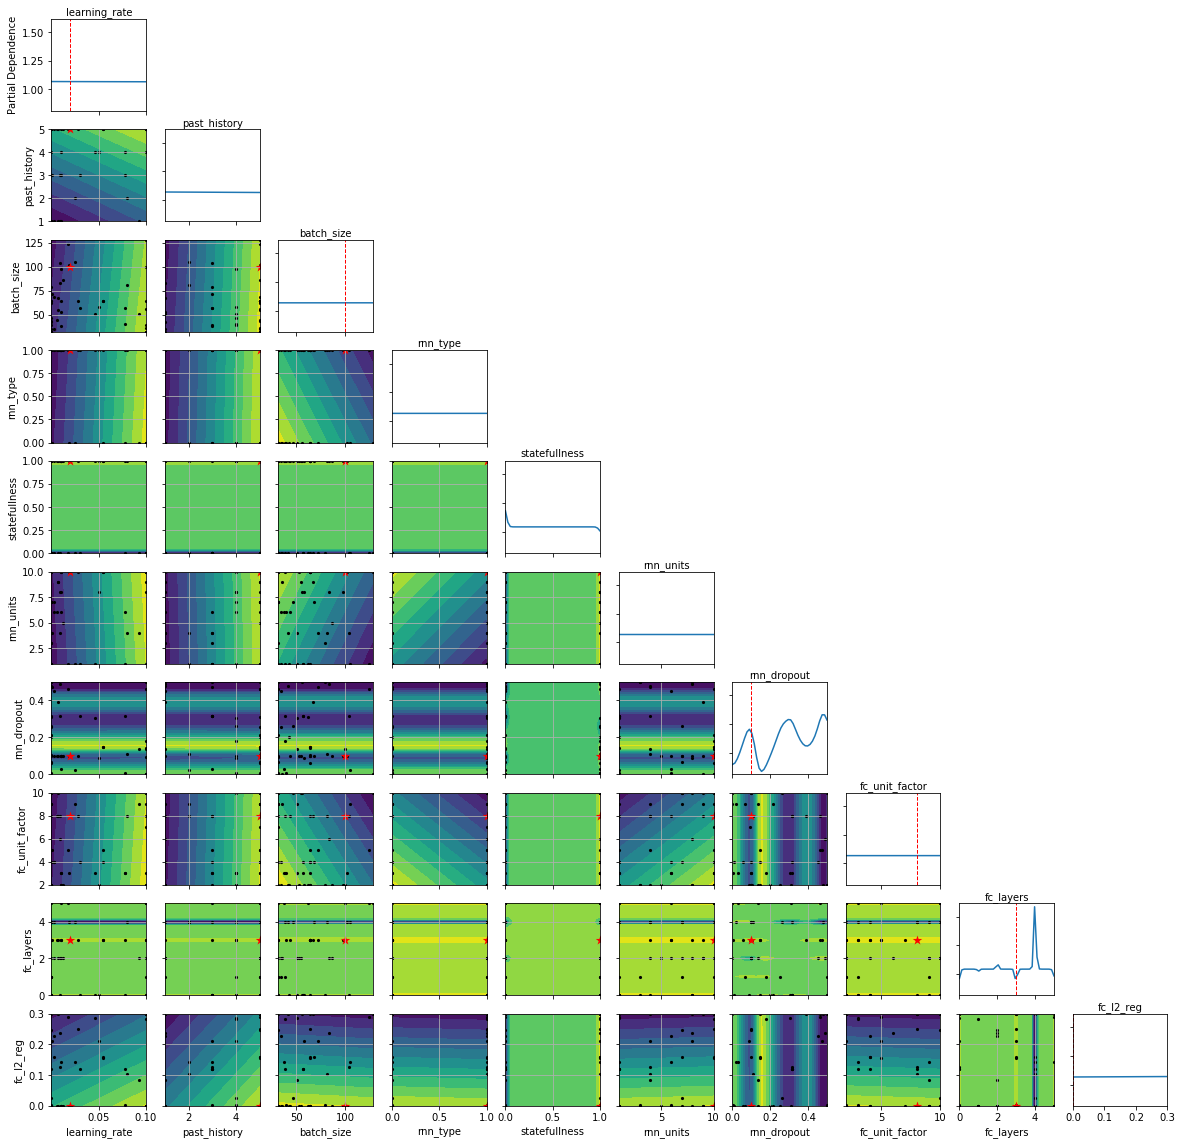

In [14]:
# extract and plot optimization results
dim_names = [
    'learning_rate',
    'past_history',
    'batch_size',
    'rnn_type',
    'statefullness',
    'rnn_units',
    'rnn_dropout',
    'fc_unit_factor',
    'fc_layers',
    'fc_l2_reg'
]

fig, ax = plot_objective(result=search_result, dimension_names=dim_names)
plt.savefig('../project_info/figures/small_scale_RNN_GPO.png', bbox_inches='tight')

In [15]:
# winning hyperparameters
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.019290905735789673,
 'past_history': 5,
 'batch_size': 100,
 'rnn_type': 1,
 'statefullness': 1,
 'rnn_units': 10,
 'rnn_dropout': 0.09976750545752072,
 'fc_unit_factor': 8,
 'fc_layers': 3,
 'fc_l2_reg': 0.0}

In [16]:
# set up training run with winning values
learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']
batch_size = winning_hyperparams['batch_size']
rnn_type = winning_hyperparams['rnn_type']
statefullness = winning_hyperparams['statefullness']
rnn_units = winning_hyperparams['rnn_units']
rnn_dropout = winning_hyperparams['rnn_dropout']
fc_unit_factor = winning_hyperparams['fc_unit_factor']
fc_layers = winning_hyperparams['fc_layers']
fc_l2_reg = winning_hyperparams['fc_l2_reg']

In [17]:
# learning_rate = 0.001
# past_history = 5
# batch_size = 1
# rnn_type = 0 # 1 = GRU, 0 = LSTM
# statefullness = 1
# rnn_units = 5
# rnn_dropout = 0.2
# fc_unit_factor = 3
# fc_layers = 4
# fc_l2_reg = 0.1

# step = 1
# future_target = 1

In [18]:
# create data sets
x_training, y_training, training_lats, training_lons, training_dates = data_functions.format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_validation, y_validation, validation_lats, validation_lons, validation_dates = data_functions.format_features_labels_for_LSTM(
    validation_data,      # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_testing, y_testing, testing_lats, testing_lons, testing_dates = data_functions.format_features_labels_for_LSTM(
    testing_data,         # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)
x_validation, y_validation = data_functions.trim_and_reshape_for_LSTM(x_validation, y_validation)
x_testing, y_testing = data_functions.trim_and_reshape_for_LSTM(x_testing, y_testing)

# trim datasets so they are a whole number factor of the batch size
for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % batch_size))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

y_training = np.delete(y_training, range(start_index, end_index), axis=0)

for i in range(len(x_validation)):
    start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % batch_size))
    end_index = x_validation[i].shape[0]

    x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

for i in range(len(x_testing)):
    start_index = (x_testing[i].shape[0] - (x_testing[i].shape[0] % batch_size))
    end_index = x_testing[i].shape[0]

    x_testing[i] = np.delete(x_testing[i], range(start_index, end_index), axis=0)

y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)

print()
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))
print()

input_dim = x_training[0].shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])
num_bins = len(x_training)
print(f'Input shape: {input_shape}')
print(f'Num bins: {num_bins}')
print()

# steps from batch size
steps_per_epoch = int(len(x_training[0]) // batch_size)
validation_steps = int(len(x_validation[0]) // batch_size)


x_training is <class 'list'>, length: 3, member shape: (3500, 5, 10).
y_training is <class 'numpy.ndarray'>, length: 3500, member shape: (3,).

x_validation is <class 'list'>, length: 3, member shape: (3500, 5, 10).
y_validation is <class 'numpy.ndarray'>, length: 3500, member shape: (3,).

x_testing is <class 'list'>, length: 3, member shape: (1700, 5, 10).
y_testing is <class 'numpy.ndarray'>, length: 1700, member shape: (3,).

Input shape: (100, 5, 10)
Num bins: 3



In [19]:
# fc_unit_factor = 0
# fc_layers = 0
# fc_l2_reg = 0

model = make_model(
    num_bins,
    input_shape,
    learning_rate,
    rnn_type,
    statefullness,
    rnn_units,
    rnn_dropout,
    fc_unit_factor,
    fc_layers,
    fc_l2_reg,
    class_0_weight,
    class_1_weight,
    output_bias
)   

In [20]:
%%time
tracemalloc.start()

history = model.fit(
    x_training,
    y_training,
    epochs=50,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping_callback],
    validation_data=(x_validation, y_validation),
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/50
35/35 [==============================] - 4s 109ms/step - loss: 1.2138 - true_positives: 667.0000 - false_positives: 6165.0000 - true_negatives: 13747.0000 - false_negatives: 385.0000 - auc: 0.6350 - matthews_correlation: 0.0231 - f1: 0.0580 - val_loss: 0.7241 - val_true_positives: 33.0000 - val_false_positives: 1923.0000 - val_true_negatives: 7994.0000 - val_false_negatives: 550.0000 - val_auc: 0.5789 - val_matthews_correlation: -0.0943 - val_f1: 0.0223
Epoch 2/50
35/35 [==============================] - 1s 31ms/step - loss: 0.6978 - true_positives: 284.0000 - false_positives: 4024.0000 - true_negatives: 6007.0000 - false_negatives: 185.0000 - auc: 0.6475 - matthews_correlation: 0.0824 - f1: 0.1081 - val_loss: 0.6781 - val_true_positives: 260.0000 - val_false_positives: 2986.0000 - val_true_negatives: 6931.0000 - val_false_negatives: 323.0000 - val_auc: 0.6294 - val_matthews_correlation: -2.5937e-04 - val_f1: 0.0822
Epoch 3/50
35/35 [==============================] - 1s 29ms

Total observations: 10519


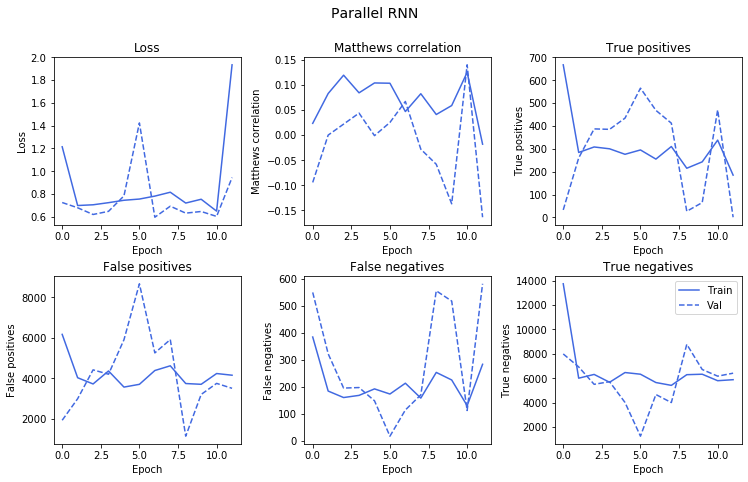

In [21]:
# plot learning curves
metric_names =  [
    'loss', 
    'matthews_correlation', 
    'true_positives', 
    'false_positives', 
    'false_negatives', 
    'true_negatives'
]

filename = '../project_info/figures/small_scale_parallel_RNN_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Parallel RNN', history, metric_names, filename)

In [22]:
%%time
tracemalloc.start()

training_predictions = model.predict(x_training, batch_size=batch_size)
training_ignition_risk_predictions = training_predictions.flatten()
training_true_fires = y_training.flatten()

testing_predictions = model.predict(x_testing, batch_size=batch_size)
testing_ignition_risk_predictions = testing_predictions.flatten()
testing_true_fires = y_testing.flatten()

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f'Peak memory: {np.round((peak / 10**6), 1)} MB')

Peak memory: 34.7 MB
CPU times: user 2.1 s, sys: 72.7 ms, total: 2.17 s
Wall time: 2.11 s


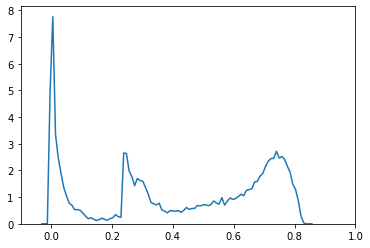

In [23]:
sns.kdeplot(training_ignition_risk_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()

In [24]:
%%time
tracemalloc.start()

training_results = model.evaluate(
    x_training,
    y_training,
    batch_size=batch_size
)

testing_results = model.evaluate(
    x_testing,
    y_testing, 
    batch_size=batch_size
)

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f'Peak memory: {np.round((peak / 10**6), 1)} MB')

17/17 [==============================] - 0s 11ms/step - loss: 0.6273 - true_positives: 240.0000 - false_positives: 2748.0000 - true_negatives: 2057.0000 - false_negatives: 55.0000 - auc: 0.6770 - matthews_correlation: 0.0597 - f1: 0.1072
Peak memory: 2.3 MB
CPU times: user 859 ms, sys: 77.3 ms, total: 937 ms
Wall time: 785 ms



Training data prediction results
No fire (True Negatives):  5584
False alarms (False Positives):  4447
Fires missed (False Negatives):  77
Fires detected (True Positives):  392
Total fires:  469

Test data prediction results
No fire (True Negatives):  2057
False alarms (False Positives):  2748
Fires missed (False Negatives):  55
Fires detected (True Positives):  240
Total fires:  295


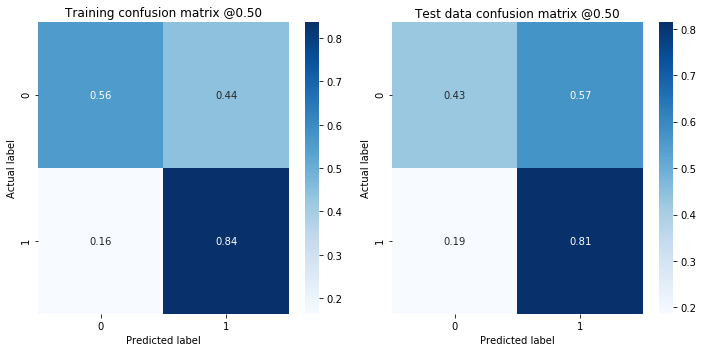

In [25]:
filename ='../project_info/figures/small_scale_parallel_RNN_confusion_matricies.png'  
plotting_functions.plot_cm(training_true_fires, training_ignition_risk_predictions, testing_true_fires, testing_ignition_risk_predictions, filename)

In [26]:
trimmed_training_dates = training_dates[:training_predictions.shape[0]]

formatted_predictions = pd.DataFrame(columns=['date', 'lat', 'lon', 'prediction'])

for prediction, date in zip(training_predictions, trimmed_training_dates):
    df = pd.DataFrame(list(zip(training_lats, training_lons, prediction)), 
               columns =['lat', 'lon', 'prediction'])
    
    df['date'] = date
    
    formatted_predictions = formatted_predictions.append(df)
    
formatted_predictions.head()

,date,lat,lon,prediction
0,1992-01-01,35.232731,-117.260803,0.000020
1,1992-01-01,37.182751,-121.959801,0.342379
2,1992-01-01,41.552299,-123.944199,0.003584
0,1992-01-02,35.232731,-117.260803,0.000005
1,1992-01-02,37.182751,-121.959801,0.360500


In [27]:
formatted_predictions.tail()

,date,lat,lon,prediction
1,2001-07-30,37.182751,-121.959801,0.695677
2,2001-07-30,41.552299,-123.944199,0.679969
0,2001-07-31,35.232731,-117.260803,0.683375
1,2001-07-31,37.182751,-121.959801,0.714638
2,2001-07-31,41.552299,-123.944199,0.701634


In [28]:
states_shapefile = '../training_data_pipeline/data/spatial_data/cb_2018_us_state_500k.shp'
california = data_functions.get_california_polygon(states_shapefile)
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

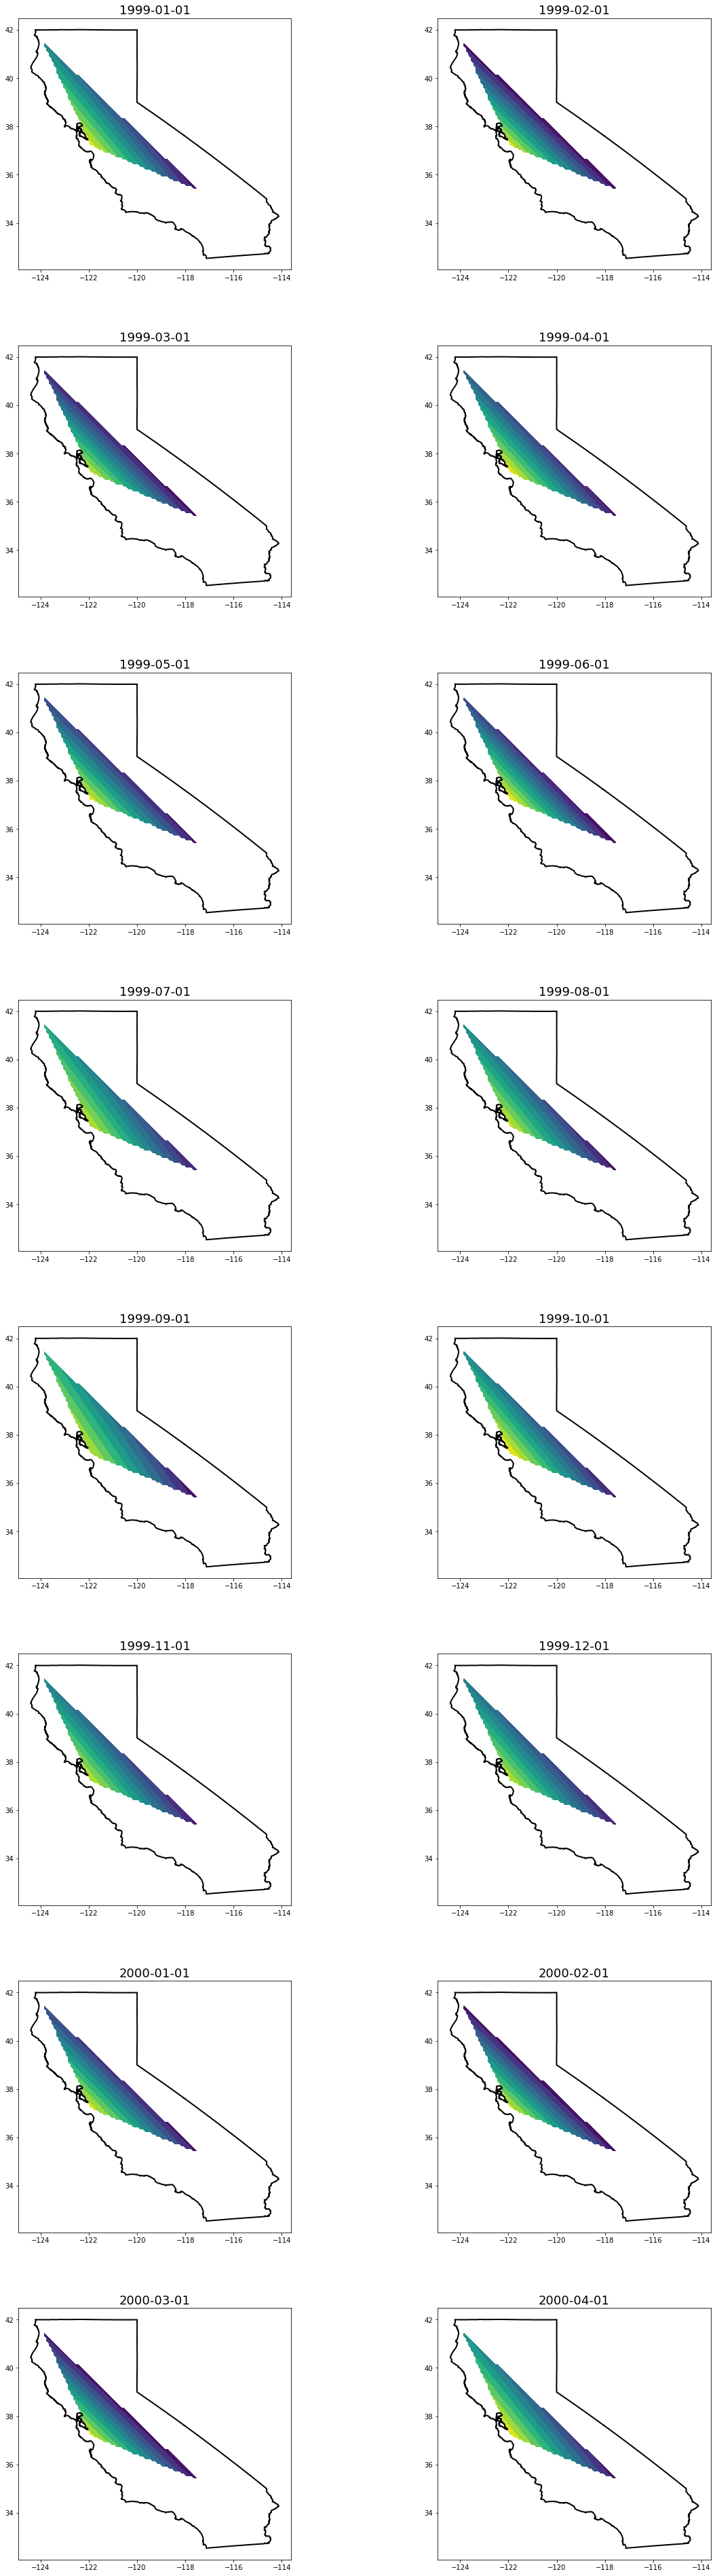

In [29]:
from descartes import PolygonPatch

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 8
fig_cols = 2
plot_height = 65
plot_width = 30

plot_locations = [
    (0,0),(0,1),
    (1,0),(1,1),
    (2,0),(2,1),
    (3,0),(3,1),
    (4,0),(4,1),
    (5,0),(5,1),
    (6,0),(6,1),
    (7,0),(7,1)
]

date_list = [
    '1999-01-01',
    '1999-02-01',
    '1999-03-01',
    '1999-04-01',
    '1999-05-01',
    '1999-06-01',
    '1999-07-01',
    '1999-08-01',
    '1999-09-01',
    '1999-10-01',
    '1999-11-01',
    '1999-12-01',
    '2000-01-01',
    '2000-02-01',
    '2000-03-01',
    '2000-04-01'
    
]

# date_list = [
#     '1999-01-01',
#     '1999-01-02',
#     '1999-01-03',
#     '1999-01-04',
#     '1999-01-05',
#     '1999-01-06',
#     '1999-01-07',
#     '1999-01-08',
#     '1999-01-09',
#     '1999-01-10',
#     '1999-01-11',
#     '1999-01-12',
#     '2000-01-13',
#     '2000-01-14',
#     '2000-01-15',
#     '2000-01-16'  
# ]

num_contour_levels = 10

# formatted_predictions['lat'] = formatted_predictions['lat'].astype('float32')
# formatted_predictions['lon'] = formatted_predictions['lon'].astype('float32')

# prediction_data_by_day = formatted_predictions.groupby('date')

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

i = 0

while i < 16:
    date = str(date_list[i])
    predictions = formatted_predictions[formatted_predictions['date'] == date]
    predictions.drop('date', axis=1, inplace=True)

    xi, yi, zi = data_functions.regularize_grid(predictions, 'prediction', 0.1)

    ax[plot_locations[i]].add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', lw='2', zorder=2))
    ax[plot_locations[i]].contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
    ax[plot_locations[i]].set_title(date, fontsize=18)
    ax[plot_locations[i]].set_aspect('equal', adjustable='box')
    
    i += 1

### Full dataset

In [30]:
#raw_data.drop(['month'], inplace=True, axis=1)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 14 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   lat               float32       
 2   lon               float32       
 3   apcp              float32       
 4   mean_air_2m       float32       
 5   mean_rhum_2m      float32       
 6   mean_dpt_2m       float32       
 7   mean_pres_sfc     float32       
 8   mean_uwnd_10m     float32       
 9   mean_vwnd_10m     float32       
 10  mean_cloud_cover  float32       
 11  ignition          int32         
 12  raw_lat           float32       
 13  raw_lon           float32       
dtypes: datetime64[ns](1), float32(12), int32(1)
memory usage: 205.7 MB


In [31]:
class_0_weight = ()
class_1_weight = ()
bins = raw_data.groupby(['raw_lat', 'raw_lon'])

for name, spatial_bin in bins:
    fires = spatial_bin['ignition'].sum()
    
    if fires == 0:
        class_0_weight = class_0_weight + (1,)
        class_1_weight = class_1_weight + (1,)
    
    else:
        observations = len(spatial_bin)
        class_0_weight = class_0_weight + (((1 / (observations - fires))*(observations)/2.0),)
        class_1_weight = class_1_weight + (((1 / fires)*(observations)/2.0),)

In [32]:
num_fires = raw_data['ignition'].sum()
total_observations = len(raw_data)
raw_output_bias = np.log([num_fires/(total_observations - num_fires)])[0]
output_bias = tf.keras.initializers.Constant(raw_output_bias)

print(f'Output bias: {raw_output_bias}')

Output bias: -3.3301765288755347


In [33]:
# make sure data is STILL sorted by date
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data = raw_data.set_index('date')
raw_data = raw_data.sort_index()
raw_data.reset_index(inplace=True)

# Split data up into training, testing and validation sets
testing_data = raw_data.tail(int(len(raw_data) * 0.2))
leftover_data = raw_data.head(int(len(raw_data) * 0.8))
validation_data = raw_data.tail(int(len(leftover_data) * 0.5))
training_data = raw_data.head(int(len(leftover_data) * 0.5))

In [34]:
future_target = 1
step = 1
EPOCHS = 30

# create data sets
x_training, y_training, training_lats, training_lons, training_dates = data_functions.format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_validation, y_validation, validation_lats, validation_lons, validation_dates = data_functions.format_features_labels_for_LSTM(
    validation_data,      # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_testing, y_testing, testing_lats, testing_lons, testing_dates = data_functions.format_features_labels_for_LSTM(
    testing_data,         # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)
x_validation, y_validation = data_functions.trim_and_reshape_for_LSTM(x_validation, y_validation)
x_testing, y_testing = data_functions.trim_and_reshape_for_LSTM(x_testing, y_testing)

# trim datasets so they are a whole number factor of the batch size
for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % batch_size))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

y_training = np.delete(y_training, range(start_index, end_index), axis=0)

for i in range(len(x_validation)):
    start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % batch_size))
    end_index = x_validation[i].shape[0]

    x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

for i in range(len(x_testing)):
    start_index = (x_testing[i].shape[0] - (x_testing[i].shape[0] % batch_size))
    end_index = x_testing[i].shape[0]

    x_testing[i] = np.delete(x_testing[i], range(start_index, end_index), axis=0)

y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)

print()
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))
print()

input_dim = x_training[0].shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])
num_bins = len(x_training)
print(f'Input shape: {input_shape}')
print(f'Num bins: {num_bins}')
print()

# steps from batch size
steps_per_epoch = int(len(x_training[0]) // batch_size)
validation_steps = int(len(x_validation[0]) // batch_size)



x_training is <class 'list'>, length: 410, member shape: (3500, 5, 10).
y_training is <class 'numpy.ndarray'>, length: 3500, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3500, 5, 10).
y_validation is <class 'numpy.ndarray'>, length: 3500, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (1700, 5, 10).
y_testing is <class 'numpy.ndarray'>, length: 1700, member shape: (410,).

Input shape: (100, 5, 10)
Num bins: 410



In [35]:
%%time
tracemalloc.start()

# fc_unit_factor = 0
# fc_layers = 0
# fc_l2_reg = 0

model = make_model(
    num_bins,
    input_shape,
    learning_rate,
    rnn_type,
    statefullness,
    rnn_units,
    rnn_dropout,
    fc_unit_factor,
    fc_layers,
    fc_l2_reg,
    class_0_weight,
    class_1_weight,
    output_bias
)

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f'Peak memory: {np.round((peak / 10**6), 1)} MB')

Peak memory: 454.7 MB
CPU times: user 3min 8s, sys: 5.44 s, total: 3min 13s
Wall time: 3min 17s


In [36]:
%%time
tracemalloc.start()

history = model.fit(
    x_training,
    y_training,
    epochs=50,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping_callback],
    validation_data=(x_validation, y_validation),
    validation_steps=validation_steps,
    verbose=1
)

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f'Peak memory: {np.round((peak / 10**6), 1)} MB')

Epoch 1/50
35/35 [==============================] - 250s 7s/step - loss: 10880.2842 - true_positives: 23695.0000 - false_positives: 464698.0000 - true_negatives: 924172.0000 - false_negatives: 27535.0000 - auc: 0.5796 - matthews_correlation: 0.0439 - f1: 0.0402 - val_loss: 1.3172 - val_true_positives: 32704.0000 - val_false_positives: 562133.0000 - val_true_negatives: 822099.0000 - val_false_negatives: 18064.0000 - val_auc: 0.6541 - val_matthews_correlation: 0.0703 - val_f1: 0.0515
Epoch 2/50
35/35 [==============================] - 44s 1s/step - loss: 0.9329 - true_positives: 32109.0000 - false_positives: 395795.0000 - true_negatives: 988270.0000 - false_negatives: 18826.0000 - auc: 0.7307 - matthews_correlation: 0.1413 - f1: 0.0841 - val_loss: 1.2590 - val_true_positives: 34752.0000 - val_false_positives: 548694.0000 - val_true_negatives: 835538.0000 - val_false_negatives: 16016.0000 - val_auc: 0.6693 - val_matthews_correlation: 0.0626 - val_f1: 0.0621
Epoch 3/50
35/35 [=============

Epoch 18/50
35/35 [==============================] - 45s 1s/step - loss: 0.7138 - true_positives: 42396.0000 - false_positives: 830604.0000 - true_negatives: 553461.0000 - false_negatives: 8539.0000 - auc: 0.6377 - matthews_correlation: 0.0880 - f1: 0.0541 - val_loss: 0.9080 - val_true_positives: 38205.0000 - val_false_positives: 847295.0000 - val_true_negatives: 536937.0000 - val_false_negatives: 12563.0000 - val_auc: 0.5621 - val_matthews_correlation: 0.0511 - val_f1: 0.0476
Epoch 19/50
35/35 [==============================] - 44s 1s/step - loss: 0.7113 - true_positives: 42768.0000 - false_positives: 851432.0000 - true_negatives: 532633.0000 - false_negatives: 8167.0000 - auc: 0.6327 - matthews_correlation: 0.0856 - f1: 0.0546 - val_loss: 0.9086 - val_true_positives: 37395.0000 - val_false_positives: 855105.0000 - val_true_negatives: 529127.0000 - val_false_negatives: 13373.0000 - val_auc: 0.5563 - val_matthews_correlation: 0.0432 - val_f1: 0.0466
Epoch 20/50
35/35 [=================

Total observations: 1437624


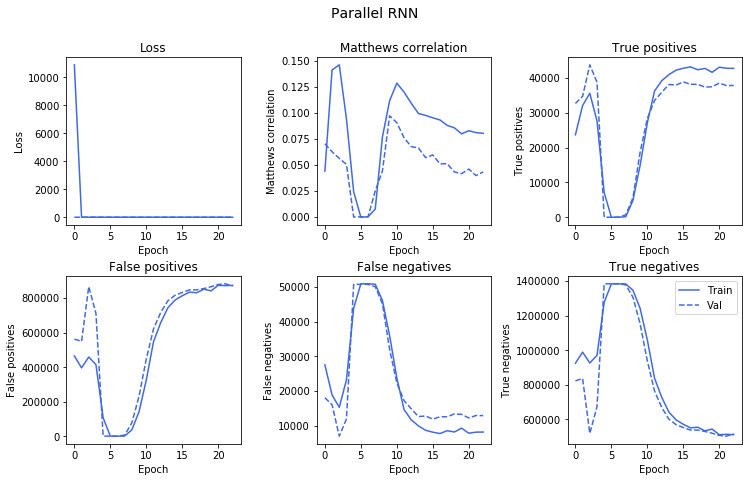

In [37]:
# plot learning curves
metric_names =  [
    'loss', 
    'matthews_correlation', 
    'true_positives', 
    'false_positives', 
    'false_negatives', 
    'true_negatives'
]

filename = '../project_info/figures/small_parallel_RNN_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Parallel RNN', history, metric_names, filename)

In [38]:
%%time
tracemalloc.start()

training_predictions = model.predict(x_training, batch_size=batch_size)
training_ignition_risk_predictions = training_predictions.flatten()
training_true_fires = y_training.flatten()

testing_predictions = model.predict(x_testing, batch_size=batch_size)
testing_ignition_risk_predictions = testing_predictions.flatten()
testing_true_fires = y_testing.flatten()

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f'Peak memory: {np.round((peak / 10**6), 1)} MB')

Peak memory: 530.6 MB
CPU times: user 3min 59s, sys: 7.23 s, total: 4min 6s
Wall time: 3min 56s



Training data prediction results
No fire (True Negatives):  541569
False alarms (False Positives):  842496
Fires missed (False Negatives):  7931
Fires detected (True Positives):  43004
Total fires:  50935

Test data prediction results
No fire (True Negatives):  259710
False alarms (False Positives):  410879
Fires missed (False Negatives):  7190
Fires detected (True Positives):  19221
Total fires:  26411


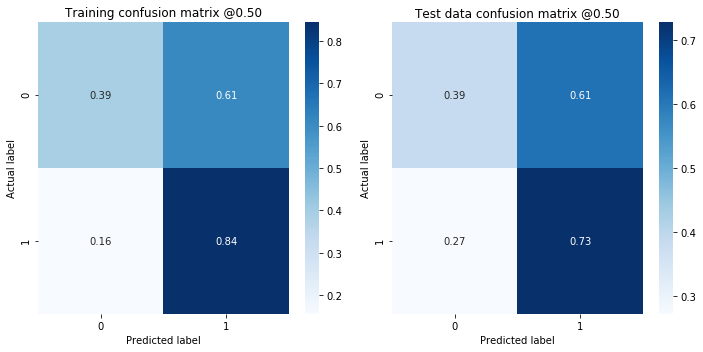

In [39]:
filename ='../project_info/figures/parallel_RNN_confusion_matricies.png'  
plotting_functions.plot_cm(training_true_fires, training_ignition_risk_predictions, testing_true_fires, testing_ignition_risk_predictions, filename)

In [40]:
trimmed_training_dates = training_dates[:training_predictions.shape[0]]

formatted_predictions = pd.DataFrame(columns=['date', 'lat', 'lon', 'prediction'])

for prediction, date in zip(training_predictions, trimmed_training_dates):
    df = pd.DataFrame(list(zip(training_lats, training_lons, prediction)), 
               columns =['lat', 'lon', 'prediction'])
    
    df['date'] = date
    
    formatted_predictions = formatted_predictions.append(df)
    
formatted_predictions.head()

,date,lat,lon,prediction
0,1992-01-01,32.683891,-117.180901,0.404595
1,1992-01-01,32.721279,-116.851196,0.558341
2,1992-01-01,32.757439,-116.521004,0.592029
3,1992-01-01,32.792389,-116.190498,0.559538
4,1992-01-01,32.826099,-115.859596,0.483772


In [41]:
states_shapefile = '../training_data_pipeline/data/spatial_data/cb_2018_us_state_500k.shp'
california = data_functions.get_california_polygon(states_shapefile)
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

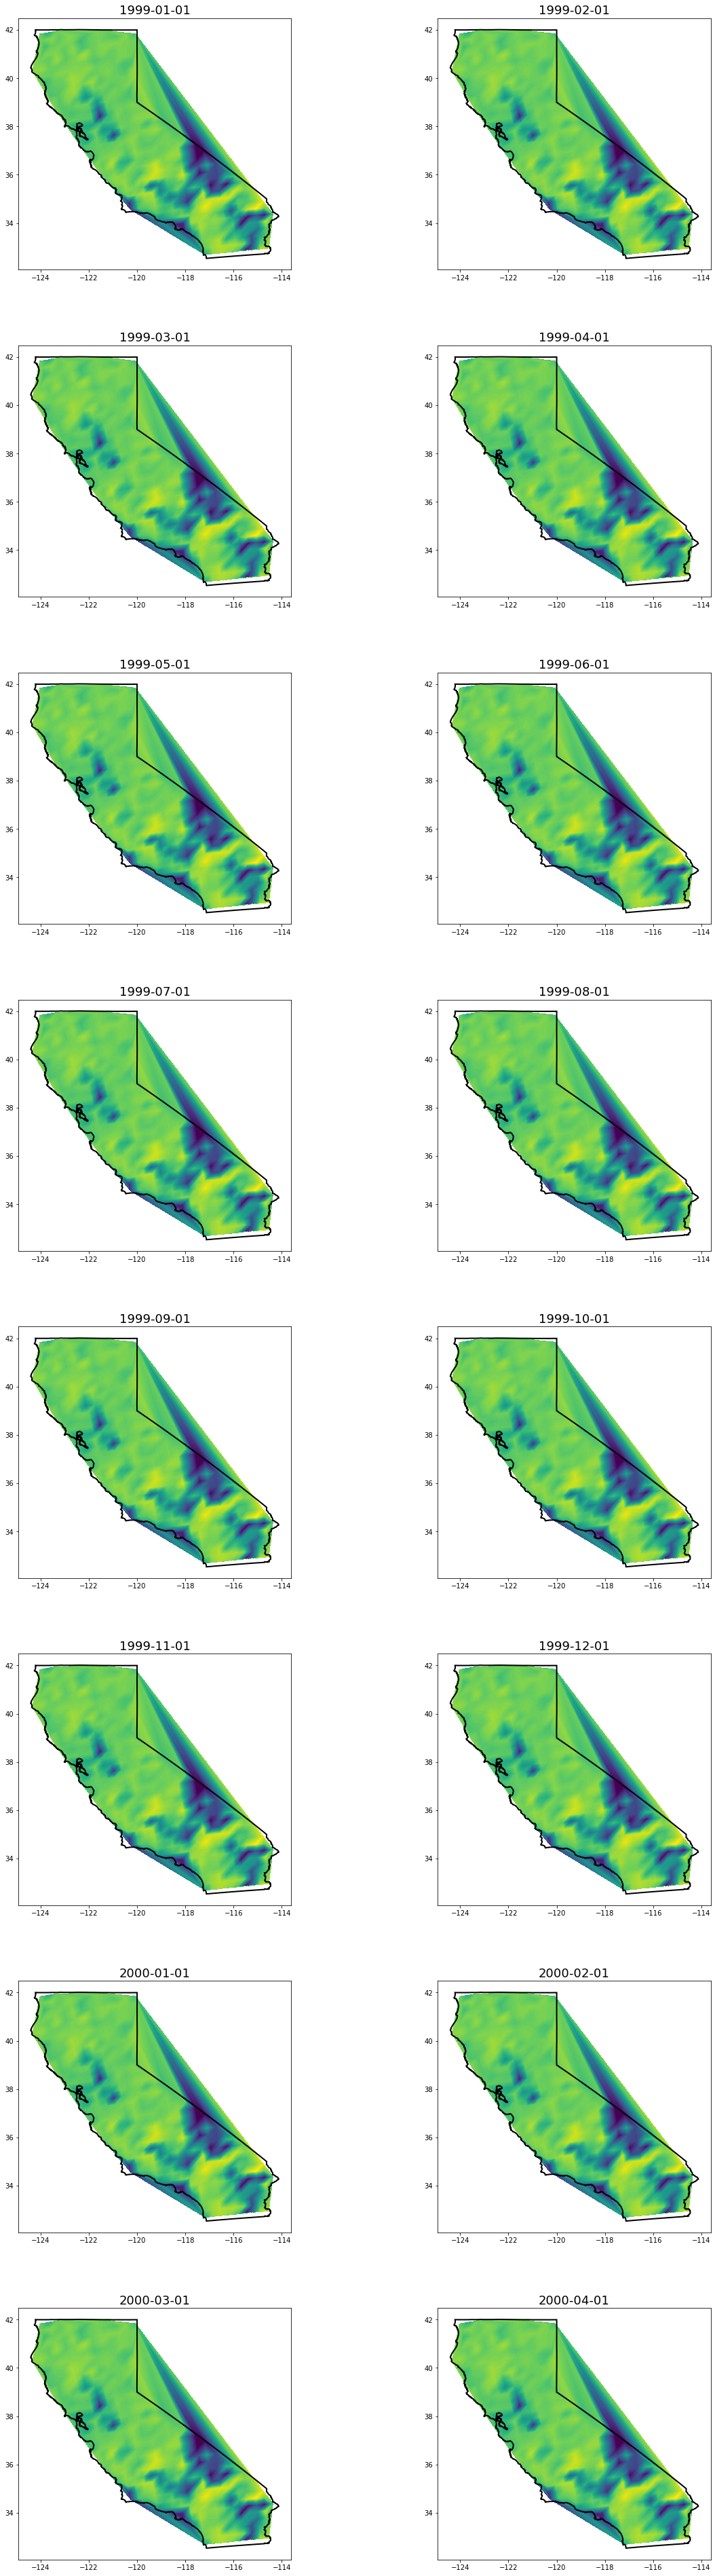

In [42]:
from descartes import PolygonPatch

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 8
fig_cols = 2
plot_height = 65
plot_width = 30

plot_locations = [
    (0,0),(0,1),
    (1,0),(1,1),
    (2,0),(2,1),
    (3,0),(3,1),
    (4,0),(4,1),
    (5,0),(5,1),
    (6,0),(6,1),
    (7,0),(7,1)
]

date_list = [
    '1999-01-01',
    '1999-02-01',
    '1999-03-01',
    '1999-04-01',
    '1999-05-01',
    '1999-06-01',
    '1999-07-01',
    '1999-08-01',
    '1999-09-01',
    '1999-10-01',
    '1999-11-01',
    '1999-12-01',
    '2000-01-01',
    '2000-02-01',
    '2000-03-01',
    '2000-04-01'
    
]

# date_list = [
#     '1999-01-01',
#     '1999-01-02',
#     '1999-01-03',
#     '1999-01-04',
#     '1999-01-05',
#     '1999-01-06',
#     '1999-01-07',
#     '1999-01-08',
#     '1999-01-09',
#     '1999-01-10',
#     '1999-01-11',
#     '1999-01-12',
#     '2000-01-13',
#     '2000-01-14',
#     '2000-01-15',
#     '2000-01-16'  
# ]

num_contour_levels = 100

# formatted_predictions['lat'] = formatted_predictions['lat'].astype('float32')
# formatted_predictions['lon'] = formatted_predictions['lon'].astype('float32')
# prediction_data_by_day = formatted_predictions.groupby('date')

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

i = 0

while i < 16:
    date = str(date_list[i])
    predictions = formatted_predictions[formatted_predictions['date'] == date]
    predictions.drop('date', axis=1, inplace=True)

    xi, yi, zi = data_functions.regularize_grid(predictions, 'prediction', 0.01)

    ax[plot_locations[i]].add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', lw='2', zorder=2))
    ax[plot_locations[i]].contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
    ax[plot_locations[i]].set_title(date, fontsize=18)
    ax[plot_locations[i]].set_aspect('equal', adjustable='box')
    
    i += 1

In [43]:
%%time

# save model note: need to use .h5 format to avoid apparent memory leak in TF 
# bug report: https://github.com/tensorflow/tensorflow/issues/32234
tracemalloc.start()

model.save('./trained_models/parallel_RNN.3.h5')

current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f'Peak memory: {np.round((peak / 10**6), 1)} MB')

Peak memory: 381.6 MB
CPU times: user 6.23 s, sys: 1.34 s, total: 7.58 s
Wall time: 7.36 s
